# Clean Volume Data
After investigating the traffic sensor data in aadt19.ipynb, clean up the entries with issues
<br>
Date: Jan 21, 2020

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
atlasdir = "S:/AdminGroups/PerformanceProgramming/RegionalTransportationPerformanceMeasures/KeyDatasets/IDOTExpresswayAtlasData/2019/"

aadt values stem from dow_date.csv in vmt_aggregation.py, so we can create a new version of dow_date.csv and then proceed from there <br>
The AASHTO calculation treats every day of the week and month the same regardless of how many days are actually present, so if the data is unreliable we should remove it.  

In [3]:
dowdate = pd.read_csv(atlasdir + "2019_grouped_files/dow_date.csv")

In [79]:
len(dowdate)

438051

In [84]:
dowdate0 = dowdate[dowdate['volume'] != 0]
# exclude where whole day has 0 volume (error or atypical day)

In [85]:
len(dowdate0)

376030

## Remove days with low counts 
Volume data was not collected at the normal frequency on these days for ~all sensors (normal is >4000 records)
* count mean less than 1000: 1/17, 2/3, 4/30
* count mean between 1000-3000: 2/1, 4/11, 5/1, 6/30, 10/21

In [4]:
lowdates = ['2019-01-17','2019-02-03','2019-04-30','2019-02-01','2019-04-11','2019-05-01','2019-06-30','2019-10-21']

In [86]:
dowdate0.head()

,date,dow,DetectorId,volume,DetectorId1
1,2019-01-17,3,2,13.0,15
2,2019-01-17,3,3,9.0,15
3,2019-01-17,3,4,47.0,15
4,2019-01-17,3,16,5.0,15
5,2019-01-17,3,17,1.0,15


In [87]:
dowdate1 = dowdate0[~dowdate0.date.isin(lowdates)]

In [88]:
len(dowdate0)

376030

In [89]:
len(dowdate1)

364930

## Remove low count days for specific sensors only
This document https://www.fhwa.dot.gov/policyinformation/tmguide/tmg_fhwa_pl_17_003.pdf says that only complete days of data are included in the calculation. <br>
Most sensors have ~4296 readings each day (20 second collection frequency).  Remove sensor/day combos that have < 2160 readings (data for half the day, or 40 second interval average).

In [90]:
dowdate1[dowdate1['DetectorId1'] < 2160].DetectorId.value_counts()
# Note that 2301-2201 are not in the lookup table/report anyway

2302     258
2301     258
2305     258
2307     258
2306     258
2304     258
2309     254
2303     232
2308     232
2202     166
2207     166
2203     166
2204     166
2205     166
2200     163
2206     153
2208     151
2201     148
5711       5
9031       5
5909       5
5606       5
9102       5
8602       5
8502       5
9601       5
9900       3
9103       2
9801       2
9032       2
9101       2
9030       2
9104       2
9029       2
6161       2
2011       1
9701       1
12345      1
Name: DetectorId, dtype: int64

In [91]:
dowdate2 = dowdate1[dowdate1['DetectorId1'] >= 2160]

In [92]:
len(dowdate1)

364930

In [93]:
len(dowdate2)

361157

## Note stations with low number of days with data
Not removing for now because may have been under construction the rest of the year or other explanation.  For context, there are 267 days in the dataset.
* Detector 2008 only has 37 days with data, and 9900 has 60 days with data
* non-count station sensors with lower number of days with data: 2833, 5606, 8602, 9031, 5909, 9601, 5711, 9701

## Filter out very high values
Volume distribution is very positively skewed.  <br>
Our VMT data from last year did not have any volumes over 150,000 <br>
IDOT Traffic Count Database System has tristate NB at 51st 2018 AADT at 156k <br>
set first max cutoff at 200,000

In [94]:
dowdate2.volume.describe()

count    3.611570e+05
mean     2.398382e+06
std      2.881250e+07
min      1.000000e+00
25%      7.431000e+03
50%      1.838900e+04
75%      2.855100e+04
max      1.035125e+09
Name: volume, dtype: float64

In [95]:
dowdate2.head()

,date,dow,DetectorId,volume,DetectorId1
1632,2019-01-18,4,2,3334.0,4296
1633,2019-01-18,4,3,9827.0,4296
1634,2019-01-18,4,4,23802.0,4296
1635,2019-01-18,4,16,8437.0,4296
1636,2019-01-18,4,17,3681.0,4296


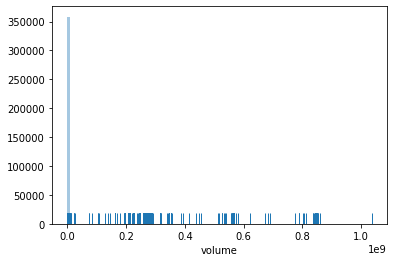

In [97]:
sns.distplot(dowdate2[(dowdate2['volume'] != 0)].volume, bins=100, rug=True, kde=False)

In [99]:
dowdate3 = dowdate2[dowdate2['volume'] <= 200000]

In [101]:
len(dowdate2)

361157

In [100]:
len(dowdate3)

357340

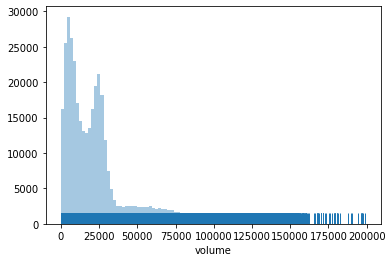

In [103]:
sns.distplot(dowdate3.volume, bins=100, rug=True, kde=False)

In [104]:
dowdate3.volume.describe()

count    357340.000000
mean      23876.825958
std       23699.237332
min           1.000000
25%        7360.000000
50%       18086.500000
75%       28123.000000
max      199098.000000
Name: volume, dtype: float64

## Filter out outliers
Use wider range of 3IQR since data has wide spread and we don't know which records are 'true'

In [117]:
iqr3 = (dowdate3.groupby('DetectorId').volume.quantile(0.75) - dowdate3.groupby('DetectorId').volume.quantile(0.25)) * 3

In [119]:
iqr3 = iqr3.reset_index()

In [121]:
q75 = dowdate3.groupby('DetectorId').volume.quantile(0.75).reset_index()

In [123]:
q25 = dowdate3.groupby('DetectorId').volume.quantile(0.25).reset_index()

In [127]:
iqr3 = iqr3.merge(q75, on='DetectorId').merge(q25, on='DetectorId')

In [133]:
iqr3 = iqr3.rename({'volume':'q25','volume_y':'q75','volume_x':'IQR3'},axis=1)

In [134]:
iqr3.head()

,DetectorId,IQR3,q75,q25
0,2,3931.50,4730.00,3419.5
1,3,3513.75,10006.75,8835.5
2,4,12454.50,25407.50,21256.0
3,16,5479.50,8973.00,7146.5
4,17,2295.00,3824.00,3059.0


In [135]:
dowdate3.head()

,date,dow,DetectorId,volume,DetectorId1
1632,2019-01-18,4,2,3334.0,4296
1633,2019-01-18,4,3,9827.0,4296
1634,2019-01-18,4,4,23802.0,4296
1635,2019-01-18,4,16,8437.0,4296
1636,2019-01-18,4,17,3681.0,4296


In [136]:
iqrmerge = dowdate3.merge(iqr3, on='DetectorId')

In [137]:
len(iqrmerge)

357340

In [138]:
len(dowdate3)

357340

In [139]:
iqrmerge.head()

,date,dow,DetectorId,volume,DetectorId1,IQR3,q75,q25
0,2019-01-18,4,2,3334.0,4296,3931.5,4730.0,3419.5
1,2019-01-19,5,2,2485.0,4296,3931.5,4730.0,3419.5
2,2019-01-20,6,2,2629.0,4295,3931.5,4730.0,3419.5
3,2019-01-21,0,2,2865.0,4296,3931.5,4730.0,3419.5
4,2019-01-22,1,2,3050.0,4296,3931.5,4730.0,3419.5


In [140]:
iqrmerge['lowlim'] = iqrmerge['q25'] - iqrmerge['IQR3']
iqrmerge['highlim'] = iqrmerge['q75'] + iqrmerge['IQR3']

In [145]:
dowdate4 = iqrmerge[(iqrmerge['volume'] > iqrmerge['lowlim']) & (iqrmerge['volume'] < iqrmerge['highlim'])]

In [146]:
len(dowdate3)

357340

In [147]:
len(dowdate4)

351098

In [158]:
(len(dowdate) - len(dowdate4)) / len(dowdate)
# in all, we removed about 20% of original records.  

0.19849971806935723

In [159]:
(len(dowdate) - len(dowdate0)) / len(dowdate)
#14% of original records were zeros.  

0.1415839708161835

In [160]:
dowdate4.to_csv(atlasdir + "2019_grouped_files/dow_date_cleaned.csv")

### appendix: boxplots

In [57]:
df = pd.read_csv(atlasdir + "2019_grouped_files/lookup_aadt_no0_blanks.csv")

In [59]:
countlist = ['3LCS','4LCS','2LCS','5LCS']

In [60]:
idlist = [x for x in (df[(df.type1.isin(countlist)) | (df.type2.isin(countlist))]).detectorid2]

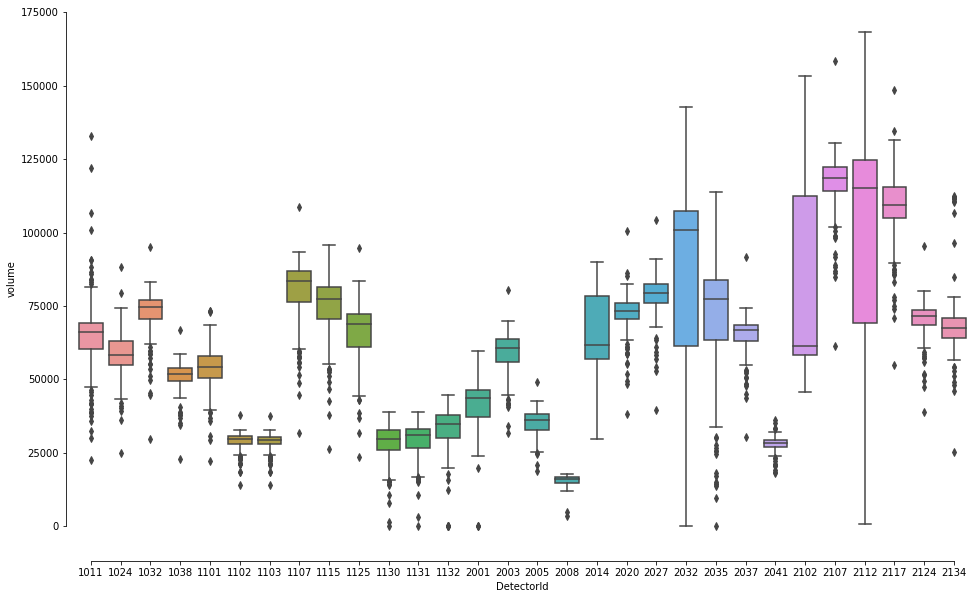

In [63]:
plt.figure(figsize=(16, 10))

sns.boxplot(x="DetectorId", y="volume",
            data=dowdate3[(dowdate3['DetectorId'].isin(idlist[0:30])) & (dowdate3['volume'] != 0)])
sns.despine(offset=10, trim=True)

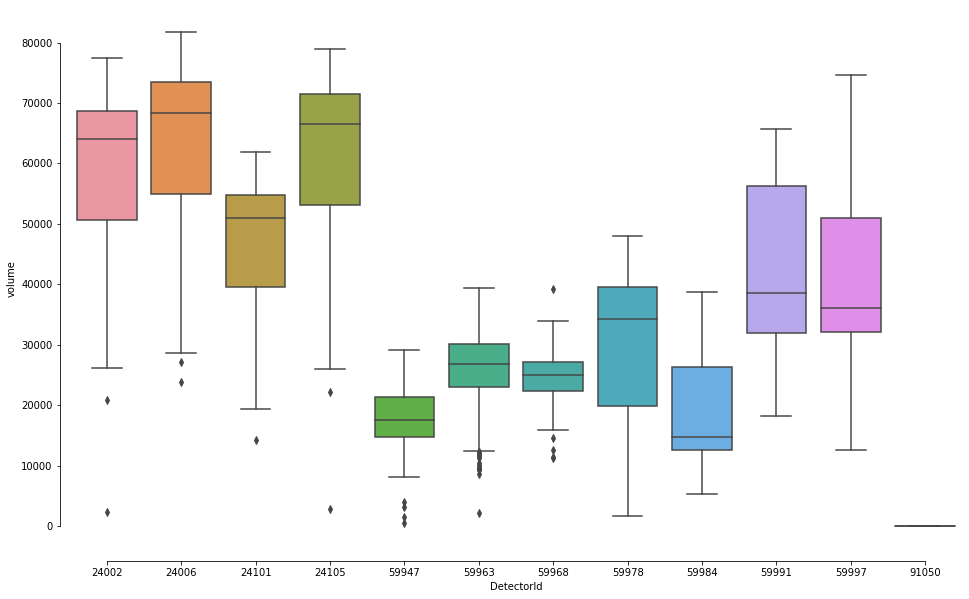

In [153]:
plt.figure(figsize=(16, 10))

sns.boxplot(x="DetectorId", y="volume",
            data=dowdate4[(dowdate4['DetectorId'].isin(idlist[181:210])) & (dowdate4['volume'] != 0)])
sns.despine(offset=10, trim=True)